# L1 norm prior experiment

This code attempts to learn the 64D prior
$J(x) = ||x||_1$
assuming we have access to training data $\{y_i, S(y_i)\}$, $S(y_i)$- using Huber function 

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/L1_prior_64D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,t=1.0):
    # Section 3.1: Convex Prior J(x) = ||x||_1
    # S(x,t) is the Moreau Envelope of the L1 norm (Huber function).
    # Per component j: if |x_j| > t: |x_j| - t/2. If |x_j| <= t: x_j^2 / 2t
    
    abs_y = np.abs(y)
    # Mask for |x| <= t
    small_mask = abs_y <= t
    
    # Component-wise values
    comps = np.zeros_like(y)
    comps[small_mask] = (abs_y[small_mask]**2) / (2 * t)
    comps[~small_mask] = abs_y[~small_mask] - (t / 2.0)
    
    # Sum across dimensions (separable)
    return np.sum(comps, axis=1)


def prior_true(y):
    # J(x) = ||x||_1
    return np.sum(np.abs(y), axis=1)


def cvx_true(y,t=1.0):
    '''
    Computes Psi(y) = 0.5*||y||^2 - S(y,t).
    The target convex function to learn.
    '''
    return 0.5 * euclid_norm_sq(y) - hjsol_true(y, t)


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,t=1.0) 
    x2_0_cvx_true = cvx_true(x2_0_points,t=1.0)

    x1_0_prior_true = prior_true(x1_0_points)
    x2_0_prior_true = prior_true(x2_0_points)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_cvx_est, "-", label="LPN")
    plt.plot(xi, x1_0_cvx_true, "--", label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the convex function, Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Convex functions(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_cvx_est, "-", label="LPN")
        plt.plot(xi, x2_0_cvx_true, "--", label="Ref")
        plt.grid(True)
        plt.title(f"Cross sections ($0,x_2$,0) of the convex function, Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Convex functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_prior_est, "-",label="LPN")
    plt.plot(xi, x1_0_prior_true, "-",label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the prior function,Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_prior_est, "-", label="LPN")
        plt.plot(xi, x2_0_prior_true, "-", label="Ref")
        plt.grid("on")
        plt.title(f"Cross sections ($0,x_2$,0) of the prior function,Dim {dim}")
        plt.xlabel('$x_1$')
        plt.ylabel('Prior functions ($0,x_2$,0)')
        plt.legend()
    plt.tight_layout()

def plot_all(model,a,spacing,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 64

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 20000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,t=1.0).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 5388.21484375
iteration 0 loss 1802.1451416015625


iteration 5000 loss 0.3132403492927551


iteration 10000 loss 0.0729026049375534


iteration 15000 loss 0.023504072800278664


iteration 20000 loss 0.005034780129790306


iteration 25000 loss 0.004428459797054529


iteration 30000 loss 0.05735263600945473


iteration 35000 loss 0.0025449781678617


iteration 40000 loss 0.21526898443698883


iteration 45000 loss 0.013076684437692165


iteration 50000 loss 0.016622399911284447


iteration 55000 loss 0.0011966440360993147


iteration 60000 loss 0.0012721545062959194


iteration 65000 loss 0.003417383413761854


iteration 70000 loss 0.002999407472088933


iteration 75000 loss 0.01589111238718033


iteration 80000 loss 0.0033765463158488274


iteration 85000 loss 0.011972042731940746


iteration 90000 loss 0.006035213824361563


iteration 95000 loss 0.41049760580062866


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.053058356046676636


iteration 105000 loss 1.8737009668257087e-06


iteration 110000 loss 7.312117304536514e-06


iteration 115000 loss 3.7525225593526557e-08


iteration 120000 loss 0.0006312135374173522


iteration 125000 loss 0.0014352102298289537


iteration 130000 loss 7.239789567847765e-08


iteration 135000 loss 5.6983576968150373e-08


iteration 140000 loss 0.00011622676538536325


iteration 145000 loss 4.127350550220399e-08


iteration 150000 loss 9.816868384859845e-08


iteration 155000 loss 1.3462300557876006e-05


iteration 160000 loss 0.0015516506973654032


iteration 165000 loss 2.6283982990094046e-08


iteration 170000 loss 8.967729314690587e-08


iteration 175000 loss 0.0004911015275865793


iteration 180000 loss 1.6299254639307037e-06


iteration 185000 loss 7.14678094482224e-08


iteration 190000 loss 7.748691132292151e-06


iteration 195000 loss 4.3754674550200434e-08


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.0020739741157740355


iteration 205000 loss 9.395946243273556e-10


iteration 210000 loss 1.1847441083734367e-10


iteration 215000 loss 5.612302622637344e-09


iteration 220000 loss 0.0002164054603781551


iteration 225000 loss 3.249660956994305e-11


iteration 230000 loss 6.014888587202449e-11


iteration 235000 loss 3.9037442434164404e-07


iteration 240000 loss 1.2789128049917053e-06


iteration 245000 loss 1.0310613474118213e-10


iteration 250000 loss 1.965835053852061e-06


iteration 255000 loss 5.3545925027265184e-08


iteration 260000 loss 9.067225442693783e-11


iteration 265000 loss 4.927133007148754e-11


iteration 270000 loss 1.0362752618675586e-05


iteration 275000 loss 1.5357123350767665e-09


iteration 280000 loss 8.998984335484295e-10


iteration 285000 loss 2.4286546818075294e-07


iteration 290000 loss 4.5851555885434436e-10


iteration 295000 loss 2.0883899196633138e-05


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 4.061002922828294e-11


iteration 305000 loss 2.872838945899847e-11


iteration 310000 loss 2.689994234306159e-11


iteration 315000 loss 1.2408708782718492e-10


iteration 320000 loss 3.1988019871809215e-11


iteration 325000 loss 1.4135802250958562e-10


iteration 330000 loss 2.386785524777224e-07


iteration 335000 loss 2.6482302462049745e-11


iteration 340000 loss 4.455374402745349e-10


iteration 345000 loss 2.340304339210064e-10


iteration 350000 loss 3.456734551376961e-11


iteration 355000 loss 3.407851352221769e-07


iteration 360000 loss 6.948969257791759e-07


iteration 365000 loss 2.4548352933750905e-11


iteration 370000 loss 2.960005157648382e-11


iteration 375000 loss 2.4518520894134532e-11


iteration 380000 loss 1.296422830199262e-10


iteration 385000 loss 1.9042709076266817e-10


iteration 390000 loss 2.4919425897773628e-11


iteration 395000 loss 2.4647305030267574e-11


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 3.400564205224832e-11


iteration 405000 loss 1.8384940236870762e-09


iteration 410000 loss 2.403830780262073e-11


iteration 415000 loss 2.3782921812487423e-11


iteration 420000 loss 5.322362689463844e-11


iteration 425000 loss 2.183776770525725e-10


iteration 430000 loss 2.4359904718385117e-11


iteration 435000 loss 2.341403113059748e-11


iteration 440000 loss 3.470272957883935e-08


iteration 445000 loss 2.426968348512304e-11


iteration 450000 loss 2.429223835975769e-11


iteration 455000 loss 2.3858592185233007e-11


iteration 460000 loss 2.972155854763514e-11


iteration 465000 loss 1.202090094132302e-10


iteration 470000 loss 2.3966276879727744e-11


iteration 475000 loss 2.425585947374298e-11


iteration 480000 loss 2.2797029888832476e-11


iteration 485000 loss 2.426968348512304e-11


iteration 490000 loss 2.397646317597868e-11


iteration 495000 loss 2.3098982795954903e-11


L2 loss -- Plot

loss -74.72499084472656


loss -280.6909484863281


loss -404.5910949707031


loss -500.0440673828125


loss -587.640869140625


loss -670.5776977539062


loss -749.2683715820312


loss -823.5039672851562


loss -892.7816162109375


loss -956.39599609375


loss -1013.6293334960938


loss -1064.0328369140625


loss -1107.5546875


loss -1144.409423828125


loss -1174.888916015625


loss -1199.33740234375


loss -1218.18408203125


loss -1231.9947509765625


loss -1241.540283203125


loss -1247.7435302734375


loss -1251.5146484375


loss -1253.628173828125


loss -1254.693115234375


loss -1255.1588134765625


loss -1255.32763671875


loss -1255.375244140625


loss -1255.3848876953125


loss -1255.38623046875


loss -1255.38623046875


loss -1255.3863525390625


loss -1255.38623046875


loss -1255.3863525390625


loss -1255.3863525390625


loss -1255.3863525390625


loss -1255.38623046875


loss -1255.38623046875


loss -1255.38623046875


loss -1255.38623046875


loss -1255.3863525390625


loss -1255.38623046875


final mse:  5.675930281334729e-10
max, min: 9.692962 -9.7505045
loss -74.72499084472656


loss -279.454833984375


loss -402.62109375


loss -496.17864990234375


loss -581.1849975585938


loss -661.2027587890625


loss -736.586669921875


loss -807.09912109375


loss -872.39990234375


loss -932.170654296875


loss -986.0639038085938


loss -1033.671875


loss -1074.679931640625


loss -1109.0047607421875


loss -1136.8270263671875


loss -1158.6376953125


loss -1175.22509765625


loss -1187.4925537109375


loss -1196.2685546875


loss -1202.281982421875


loss -1206.177490234375


loss -1208.5196533203125


loss -1209.792236328125


loss -1210.39453125


loss -1210.6314697265625


loss -1210.7041015625


loss -1210.72021484375


loss -1210.7225341796875


loss -1210.7227783203125


loss -1210.722900390625


loss -1210.7227783203125


loss -1210.7227783203125


loss -1210.722900390625


loss -1210.722900390625


loss -1210.7227783203125


loss -1210.72265625


loss -1210.722900390625


loss -1210.7227783203125


loss -1210.722900390625


loss -1210.7227783203125


final mse:  5.621371146347087e-10
max, min: 9.971468 -9.635308


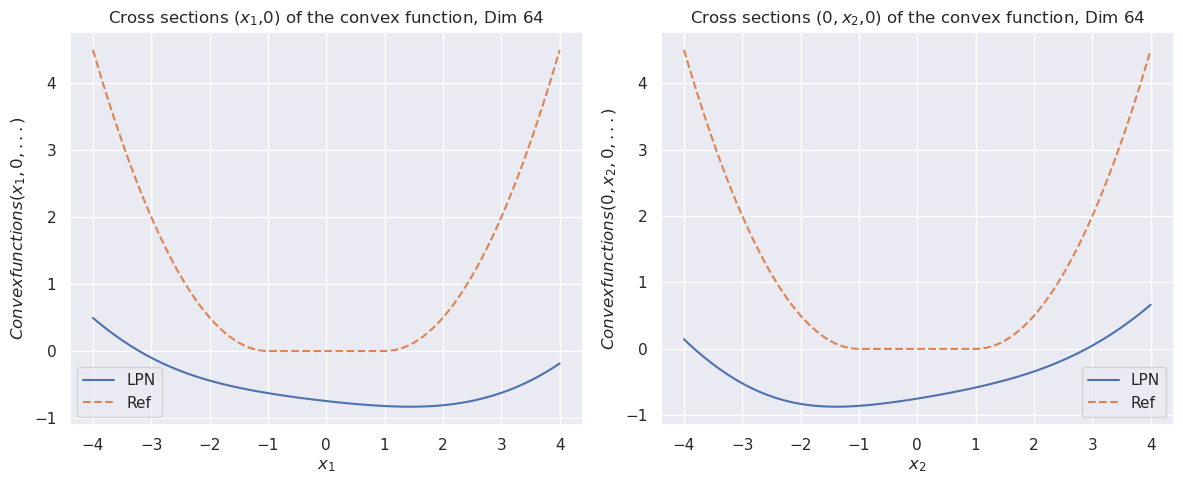

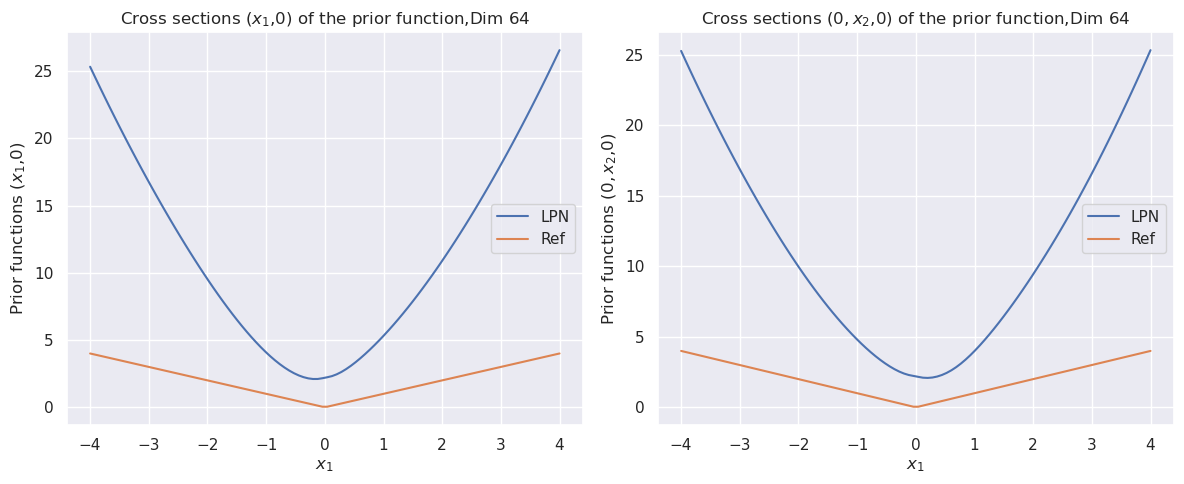

In [7]:
plot_all(lpn_model,a,spacing,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device)

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 6629.46533203125
iteration 0 loss 3524.72314453125


iteration 5000 loss 0.23556144535541534


iteration 10000 loss 0.01741873286664486


iteration 15000 loss 0.0038903402164578438


iteration 20000 loss 0.0017301624175161123


iteration 25000 loss 0.017176933586597443


iteration 30000 loss 0.0007255338132381439


iteration 35000 loss 0.04486715421080589


iteration 40000 loss 0.000526374438777566


iteration 45000 loss 0.0004190879699308425


iteration 50000 loss 0.007836512289941311


iteration 55000 loss 0.00031301111448556185


iteration 60000 loss 0.0003515193238854408


iteration 65000 loss 0.0004278663545846939


iteration 70000 loss 0.0003276020288467407


iteration 75000 loss 0.00028042259509675205


iteration 80000 loss 0.0019064242951571941


iteration 85000 loss 0.00027301779482513666


iteration 90000 loss 0.00211913138628006


iteration 95000 loss 0.0002069340116577223


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.00014804158126935363


iteration 105000 loss 1.7839871361502446e-05


iteration 110000 loss 1.2975625622857478e-06


iteration 115000 loss 2.0359888708298968e-07


iteration 120000 loss 6.381750239370376e-08


iteration 125000 loss 1.3538324594719597e-07


iteration 130000 loss 3.273007465054434e-08


iteration 135000 loss 4.82873019791441e-06


iteration 140000 loss 3.186000085975138e-08


iteration 145000 loss 0.0005009789601899683


iteration 150000 loss 0.00040054062264971435


iteration 155000 loss 3.440740670157538e-08


iteration 160000 loss 3.402482562364639e-08


iteration 165000 loss 5.165776784110676e-08


iteration 170000 loss 1.9472561518796283e-07


iteration 175000 loss 6.697939056721225e-07


iteration 180000 loss 4.478469151081299e-08


iteration 185000 loss 2.5475229037397185e-08


iteration 190000 loss 2.5119149427155207e-08


iteration 195000 loss 3.4884259036971343e-08


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.0002749685663729906


iteration 205000 loss 6.9014354231455854e-09


iteration 210000 loss 1.8867998274885167e-09


iteration 215000 loss 1.0926483184903191e-07


iteration 220000 loss 4.5875567233899517e-10


iteration 225000 loss 2.794491582580605e-10


iteration 230000 loss 2.0198931416359756e-10


iteration 235000 loss 9.125567856926864e-09


iteration 240000 loss 1.180938818956534e-10


iteration 245000 loss 1.236126895287626e-10


iteration 250000 loss 1.1757292361913585e-10


iteration 255000 loss 1.1958908863185513e-10


iteration 260000 loss 9.383584187450111e-11


iteration 265000 loss 8.323331607273943e-11


iteration 270000 loss 1.0417715995414412e-10


iteration 275000 loss 7.063208351532069e-11


iteration 280000 loss 1.2410164562659531e-10


iteration 285000 loss 3.304747031585009e-10


iteration 290000 loss 2.50051328976042e-07


iteration 295000 loss 8.714341748206067e-11


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 7.46868451528826e-08


iteration 305000 loss 6.299451238422904e-11


iteration 310000 loss 4.5343038351797205e-11


iteration 315000 loss 4.2773170422227835e-11


iteration 320000 loss 3.464301762123867e-11


iteration 325000 loss 3.0691442443053774e-11


iteration 330000 loss 2.8906651378113324e-11


iteration 335000 loss 2.7794884449594548e-11


iteration 340000 loss 3.033128262441842e-11


iteration 345000 loss 2.84868292149687e-11


iteration 350000 loss 2.9656801320276927e-11


iteration 355000 loss 2.856104415471794e-11


iteration 360000 loss 2.7788335868472736e-11


iteration 365000 loss 2.873130032499116e-11


iteration 370000 loss 2.6364431471304073e-11


iteration 375000 loss 3.03858535555257e-11


iteration 380000 loss 2.911619903511742e-11


iteration 385000 loss 2.7805070745845484e-11


iteration 390000 loss 2.7184431788951358e-11


iteration 395000 loss 3.030436318551821e-11


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 2.7198255800331417e-11


iteration 405000 loss 2.730012049756425e-11


iteration 410000 loss 2.5820918320151875e-11


iteration 415000 loss 2.7321948523062467e-11


iteration 420000 loss 2.556553233001857e-11


iteration 425000 loss 2.6206543879414568e-11


iteration 430000 loss 2.8944485697124378e-11


iteration 435000 loss 2.5776533685295533e-11


iteration 440000 loss 2.7409987474191766e-11


iteration 445000 loss 2.694359839405802e-11


iteration 450000 loss 2.7335772534442526e-11


iteration 455000 loss 2.5431653311036584e-11


iteration 460000 loss 2.5180633619892312e-11


iteration 465000 loss 2.584492862778287e-11


iteration 470000 loss 2.4859763553264358e-11


iteration 475000 loss 2.6849737710943344e-11


iteration 480000 loss 2.4927429911891785e-11


iteration 485000 loss 2.9143847057877537e-11


iteration 490000 loss 3.098757361819082e-11


iteration 495000 loss 3.1988019871809215e-11


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


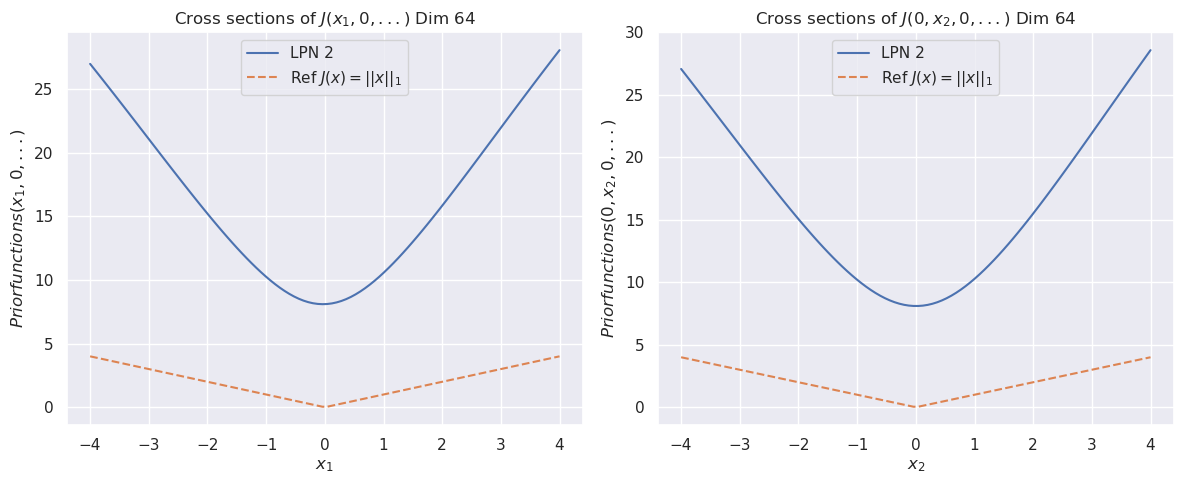

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=||x||_1$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=||x||_1$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim)